Note that the following code runs in Google Colab. Prerequisites to run the code


*   Upload data_image_classification.zip to Google Drive
*   Authorize Google Colab to access Google Drive

Author: xzhang867


## Import Packages

In [ ]:
import shutil
import cv2
import pandas as pd
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split
from google.colab import drive
from IPython.display import Image, display

## Map Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip Image Data

In [ ]:
!unzip -u "/content/drive/MyDrive/practicum/data_image_classification.zip" -d "/content/drive/MyDrive/practicum/" > data_image_classification.txt

## Data Transformation

### Get Image File Paths

In [ ]:
# get a list of image paths from /content/drive/MyDrive/practicum/data_image_classification/data
import os
file_list = []
for root, _, filenames in os.walk("/content/drive/MyDrive/practicum/data_image_classification/data"):
  for filename in filenames:
    file_list.append([filename, os.path.join(root, filename)])

df_file = pd.DataFrame(file_list, columns = ["filename", "filepath"])

# show the first 5 rows
df_file.head()

,filename,filepath
0,image-pre-inspection-photo-ce47fce3-174b-4e99-...,/content/drive/MyDrive/practicum/data_image_cl...
1,image-pre-inspection-photo-7fe9fc25-d9ec-4de3-...,/content/drive/MyDrive/practicum/data_image_cl...
2,image-post-inspection-photo-38ac2393-ee95-45d6...,/content/drive/MyDrive/practicum/data_image_cl...
3,image-pre-inspection-photo-ba662eb7-d7ac-4ac4-...,/content/drive/MyDrive/practicum/data_image_cl...
4,image-post-inspection-photo-72bd12a7-2412-4eaa...,/content/drive/MyDrive/practicum/data_image_cl...


### Read in Metadata File

In [ ]:
# read in metadata file
df_metadata = pd.read_csv("/content/drive/MyDrive/practicum/data_image_classification/classification_dataset_annotations.xlsx - Sheet1.csv")

# clean split column to have correct filename
def get_filename(s):
  result = s.split(",")[-1]
  return result[2:-2].strip()

df_metadata["filename"] = df_metadata["split"].apply(get_filename)


### Merge File Path Data and Metadata

In [ ]:
# merge df_file into df_metadata
df_metadata["filepath"] = df_metadata["filename"].map(dict(zip(df_file.filename, df_file.filepath)))

# select needed column
df_metadata = df_metadata[["filename", "filepath", "label"]]

# show the first 5 rows
df_metadata.head()

,filename,filepath,label
0,image-pre-inspection-photo-ce47fce3-174b-4e99-...,/content/drive/MyDrive/practicum/data_image_cl...,dryer
1,image-post-inspection-photo-38ac2393-ee95-45d6...,/content/drive/MyDrive/practicum/data_image_cl...,dryer
2,image-pre-inspection-photo-7fe9fc25-d9ec-4de3-...,/content/drive/MyDrive/practicum/data_image_cl...,dryer
3,image-post-inspection-photo-72bd12a7-2412-4eaa...,/content/drive/MyDrive/practicum/data_image_cl...,dryer
4,image-pre-inspection-photo-ba662eb7-d7ac-4ac4-...,/content/drive/MyDrive/practicum/data_image_cl...,dryer


In [ ]:
# show those images with short filename
df_metadata["filename_len"] = df_metadata.filename.apply(lambda x: len(x))
df_metadata["filename_len"].value_counts()

104    1865
105    1081
95      136
78      114
116      80
112      22
71        3
19        2
60        1
18        1
111       1
Name: filename_len, dtype: int64

### Manually Review Images

/content/drive/MyDrive/practicum/data_image_classification/data/Laundry/SJ48484064/David Garofalo.png


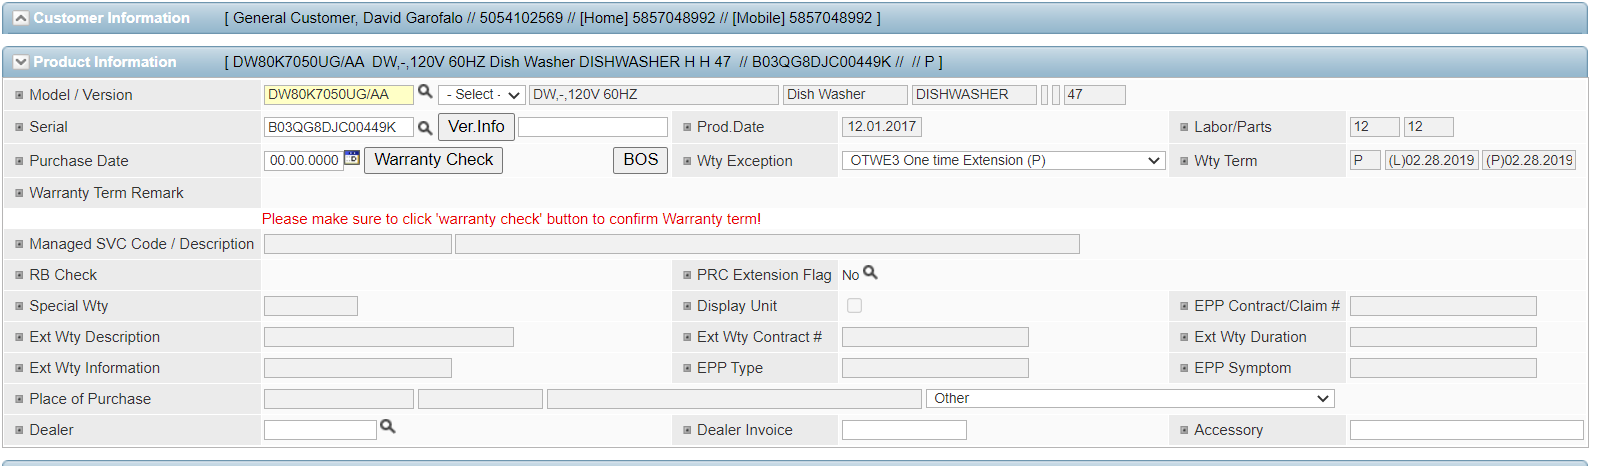

In [ ]:
for imageName in df_metadata.loc[df_metadata.filename_len <= 18, "filepath"]:
  print(imageName)
  display(Image(filename=imageName))


/content/drive/MyDrive/practicum/data_image_classification/data/SJ48173895/signature-next-steps-signature_c11ab8f2-b575-4b56-9901-2feae72382a2.png


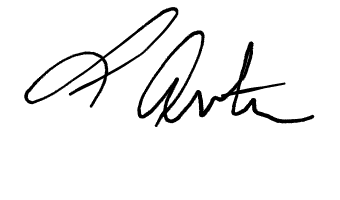

/content/drive/MyDrive/practicum/data_image_classification/data/SJ48309649/signature-next-steps-signature_32d5e8a7-c1e3-4f54-ac7f-9959a002d016.png


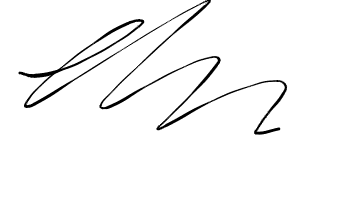

/content/drive/MyDrive/practicum/data_image_classification/data/SJ48476945/signature-next-steps-signature_e1347dd4-bdf5-44a5-8c73-a10673da8c87.png


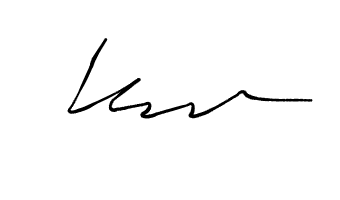

In [ ]:
# find out and show the 
for imageName in df_metadata.loc[df_metadata.filename.str.contains("signature"), "filepath"]:
  print(imageName)
  display(Image(filename=imageName))


### Remove Suspicious Images

In [ ]:
# identify image containing keyword 'signature' 
condition_a = ~df_metadata.filename.str.contains("signature")

# identify short image name
condition_b = ~df_metadata.filename_len <= 18

# remove those suspicious records
df_metadata = df_metadata.loc[condition_a & condition_b]

# reset index
df_metadata.reset_index(drop=True, inplace=True)

# show the first 5 records
df_metadata.head()

,filename,filepath,label,filename_len
0,image-pre-inspection-photo-ce47fce3-174b-4e99-...,/content/drive/MyDrive/practicum/data_image_cl...,dryer,104
1,image-post-inspection-photo-38ac2393-ee95-45d6...,/content/drive/MyDrive/practicum/data_image_cl...,dryer,105
2,image-pre-inspection-photo-7fe9fc25-d9ec-4de3-...,/content/drive/MyDrive/practicum/data_image_cl...,dryer,104
3,image-post-inspection-photo-72bd12a7-2412-4eaa...,/content/drive/MyDrive/practicum/data_image_cl...,dryer,105
4,image-pre-inspection-photo-ba662eb7-d7ac-4ac4-...,/content/drive/MyDrive/practicum/data_image_cl...,dryer,104


### Identify Corrupted Images

In [ ]:
# identify corrupted images
for i in df_metadata.filepath:
  v_image = PIL.Image.open(df_metadata.filepath[0])
  try:
    v_image.verify()
  except Exception:
    print(f'Invalid image: {i}')


## Data Exploration

In [ ]:
# get general idea on frequency counts of different appliances
df_metadata.label.value_counts()

dishwasher      984
cooking         893
washer          608
dryer           447
refrigerator    371
Name: label, dtype: int64

In [ ]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(df_metadata[["filename", "filepath"]], df_metadata["label"], test_size=0.3, stratify=df_metadata["label"], random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.33, stratify=y_rem, random_state=42)

print("train", X_train.shape, y_train.shape)
print("validataion", X_valid.shape, y_valid.shape)
print("test", X_test.shape, y_test.shape)


train (2312, 2) (2312,)
validataion (663, 2) (663,)
test (328, 2) (328,)


## Generate Folder Layout for Deep Learning Purpose

In [ ]:
# create folders for train, validation, and test 
# create sub-folders named in labels

for i in ['traing', 'validation', 'test']:
  for j in df_metadata.label.unique():
    os.makedirs(f"/content/drive/MyDrive/practicum/data_image_classification/{i}/{j}", exist_ok = True)

In [ ]:
# generate three data sets to prepare for image copying
train_data = pd.concat([X_train, y_train], axis=1)
train_data["destination"] = "/content/drive/MyDrive/practicum/data_image_classification/train/" + train_data["label"] + "/"

validation_data = pd.concat([X_valid, y_valid], axis=1)
validation_data["destination"] = "/content/drive/MyDrive/practicum/data_image_classification/validation/" + validation_data["label"] + "/"

test_data = pd.concat([X_test, y_test], axis=1)
test_data["destination"] = "/content/drive/MyDrive/practicum/data_image_classification/test/" + test_data["label"] + "/"


In [ ]:
# define a function to do image copying
def copy_to_destination(df):
  for index, row in df.iterrows():
    shutil.copy2(row["filepath"], row["destination"])

In [ ]:
# copy images to destination folders
copy_to_destination(train_data)
copy_to_destination(validation_data)
copy_to_destination(test_data)

## Understand Images

In [ ]:
size_list = list()
for i in df_metadata.filepath:
  size_list.append(f"{cv2.imread(i).shape[0]} * {cv2.imread(i).shape[1]}")

# Most pictures are 1080 * 810
pd.Series(size_list).value_counts()

1080 * 810     3211
810 * 1080       57
1080 * 549       14
1080 * 1080       7
1080 * 546        6
1080 * 547        3
1080 * 552        2
1920 * 1080       2
466 * 1601        1
dtype: int64